## Learning bi-partite motifs based on a thermodynamic approach
### import libraries and functions

In [1]:
#imports
exec(compile(open('src/load_libs.py', 'rb').read(), 'src/load_libs.py', 'exec')) 

#dynamic programming implementation of the LL class
exec(compile(open('src/LL_avx.py', 'rb').read(), 'src/LL_avx.py', 'exec')) 

#the wrapper functions, gradient descent implementation
exec(compile(open('src/ADAM_func.py', 'rb').read(), 'src/ADAM_func.py', 'exec')) 

random.seed(42)

### Import data

### RBNS

In [2]:
#RBNS DATASET
if False:
    factor_number = 0

    #define paths for RBNS dataset files
    rbp_path = '../rbns_scratch/data'
    factors = np.sort(os.listdir(rbp_path)) #list available factors

    all_files = [os.listdir(os.path.join(rbp_path, factor)) for factor in factors]

    pulldown_files = [np.sort(files)[2] for files in all_files]  #take 320 concentration when available otherwise another concentration
    input_files = [[f for f in files if '_input_' in f][0] for files in all_files]
    concentrations = [f.split('_')[1] for f in pulldown_files] #see which concentration we took

    if factor_number in range(len(factors)):
        factor = factors[factor_number]
        concentration = concentrations[factor_number]
        print(f'processing {factor}')
        bg = os.path.join(rbp_path,factor,input_files[factor_number])
        pos = os.path.join(rbp_path,factor,pulldown_files[factor_number])

    background_set = parse_fastq(bg)
    background_set = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in background_set]
    print(f'dataset has {len(background_set)} background sequences.')

    positive_set = parse_fastq(pos)
    positive_set = [seq.replace('N', random.sample(['A','T','C','G'],1)[0]) for seq in positive_set]
    print(f'dataset has {len(positive_set)} positive sequences.')

### IMP3

In [7]:
if False:
    rbp_path = '../RBP_motif_cluster/imp3_selex'
    
    background_file = 'KH12_N40_R1'
    positive_file = 'KH12_N40_R4'
    
    bg = os.path.join(rbp_path, background_file)
    pos = os.path.join(rbp_path, positive_file)

    #if the sequence misses some characters complete it with random bases

    alphabet = ['A','T','C','G']
    L = 40
    background_set = parse_seq(bg)
    background_set = [seq+''.join([random.choice(alphabet) for i in range(5)]) for seq in background_set]
    background_set = [seq[:L] for seq in background_set]

    positive_set = parse_seq(pos)
    positive_set = [seq+''.join([random.choice(alphabet) for i in range(5)]) for seq in positive_set]
    positive_set = [seq[:L] for seq in positive_set]


### PARCLIP

In [4]:
if False:
    rbp_path = 'data/Nrd1/'
    pos = os.path.join(rbp_path, 'Nrd1_start0_stop5000_width20_sort_occupancy.fa')
    
    positive_set = parse_fasta(pos)
    
    L = len(positive_set[0])
    alphabet = ['A','T','C','G']

    background_set = [''.join([random.choice(alphabet) for i in range(L)]) for i in range(len(positive_set))]

### Simulated data

In [5]:
random.seed(42)

background_set = parse_fasta('negatives_toy.fasta')
positive_set = parse_fasta('positives_toy.fasta')

In [6]:
bg_train, bg_valid = partition(background_set, 2)
pos_train, pos_valid = partition(positive_set, 2)

## Run parameter optimization 

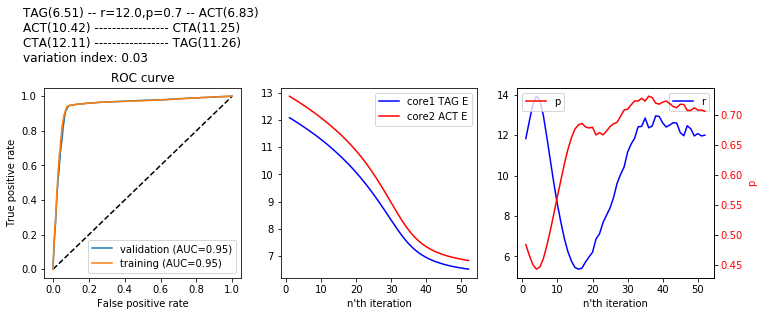

In [7]:
for i in range(0,1):
    np.random.seed(i)
    Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
    Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
    sf = np.log(10000)
    r = np.log(np.random.uniform(1,15))
    p = 0

    parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])
    
    var_thr = 0.03
    
    seq_per_batch = 500
    
    file_name = f'toy_{i}'

    maxiter=1000
    if True:
        theta_0, g_t  = optimize_adam(pos_train, bg_train, 
                              pos_valid, bg_valid, 
                              var_thr, sequences_per_batch=seq_per_batch, 
                              max_iterations=maxiter, evaluate_after=4000)
    

In [14]:
#imports
exec(compile(open('src/load_libs.py', 'rb').read(), 'src/load_libs.py', 'exec')) 

#dynamic programming implementation of the LL class
exec(compile(open('src/LL_avx.py', 'rb').read(), 'src/LL_avx.py', 'exec')) 

#the wrapper functions, gradient descent implementation
exec(compile(open('src/ADAM_func.py', 'rb').read(), 'src/ADAM_func.py', 'exec')) 

random.seed(42)

In [2]:
Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
sf = np.log(100)
r = 0.5
p = 0.5

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])

In [3]:
param = parameters
intrep = seq2int_cy('AAGAAGGCATAGTTTGCGATTTAGCGGCTGACATTAAATC')

for comp in [0,127,128,129,130]:
    epsilon = 1e-5
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = DP_Z_cy(x_fwd, intrep)[0]
    fx_rev = DP_Z_cy(x_rev, intrep)[0]
    
    print('component %d'%comp)
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(DP_Z_cy(param, intrep)[1][comp])

component 0
-4.692468635880687e-06
-4.69247594151443e-06
component 127
-1.245470393484993e-05
-1.245474638876641e-05
component 128
4.2188474935755943e-10
4.2023572600514797e-10
component 129
3.2418512319054567e-09
3.2835059284631946e-09
component 130
-4.818367926873179e-09
-4.854353684663969e-09


In [15]:
n = 100
nll_obj = nLL(positive_set[:n], background_set[:n])


Ea = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
Eb = np.random.normal(loc=12.0, scale=1.0, size=len(kmer_inx))
sf = np.log(100)
r = np.log(0.5)
p = np.log(0.5)

parameters = np.concatenate([x.ravel() for x in [Ea, Eb, np.array([sf, r, p])]])
param = parameters

for comp in [0, 127,128,129,130]:
    epsilon = 1e-5
    x_fwd = param.copy()
    x_fwd[comp] += epsilon
    x_rev = param.copy()
    x_rev[comp] -= epsilon

    fx_fwd = nll_obj(x_fwd)[0]
    fx_rev = nll_obj(x_rev)[0]
    
    print('component %d\t, 1=%f, 2=%f'%(comp, fx_fwd, nll_obj(param)[0]))
    print((fx_fwd - fx_rev)/(2*epsilon))
    print(nll_obj(param)[1][comp])

component 0	, 1=533.487452, 2=533.487451
0.03890284574481484
0.03890294468698802
component 127	, 1=533.487452, 2=533.487451
0.07215142545646813
0.07215155496568709
component 128	, 1=533.487451, 2=533.487451
0.0007133394319680518
0.0007129654955893132
component 129	, 1=533.487451, 2=533.487451
0.0003231377831980353
0.0003231206133736224
component 130	, 1=533.487451, 2=533.487451
1.5216983229038304e-05
1.563850826062949e-05
